In [1]:
from tqdm import tqdm
from D3QNAgent import Agent
from kaggle_environments import evaluate, make, utils
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

env = make("connectx", debug=True)
env.render()

nstep_lookahead_agent = './fast_Nstep_lookahead_agent.py'
random_agent = 'random'
negamax_agent = 'negamax'

Loading environment football failed: No module named 'gfootball'


In [2]:
def live_plot(rewards, i, j, eps):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(ncols=2, dpi=120, figsize=(12.8, 3.6))
    ax1.plot(np.array(rewards), color='orange', linestyle='-')
    # ax1.legend(loc='lower right')
    ax1.set_ylabel('reward')
    ax1.set_xlabel('episode')
    ax1.title.set_text('Agent Total Rewards with Moving Average 100 Episodes')

    plt.show()

    print('episode', i, 
        '\tround', j,
        # '\ttotal rewards %.1f' % tot_reward, 
        # '\taverage rewards %.3f' % avg_rewards[i], 
        # '\tresult ', reward, 
        # '\twin/loss ratio %.3f' % wl_ratio[i], 
        '\tepsilon %.3f' % eps)


In [3]:
def preprocess_board_state(observation):
    board = np.array(observation['board'], dtype=np.float32)
    marker = observation.mark
    if marker == 1:
        board[board == 1] = -1
        board[board == 2] = 1
        
    else:
        board[board == 1] = 1
        board[board == 2] = -1

    # return np.array(board, dtype=np.float32).reshape(6, 7, 1)
    return board

In [4]:
agent = Agent(
    env.configuration, 
    lr=1e-3, 
    gamma=0.99, 
    batch_size=64,    #### REMEMBER TO CHANGE IT BACK ####
    epsilon=1,        #### REMEMBER TO CHANGE IT BACK ####
    eps_dec=0.99,
    eps_min=0.1,
    buff_size=10_000,
    d1_dims=128,
    d2_dims=128,
    replace_target_weight=15
)

def playalong_agent(obs, config):
    # define agent
    agent = Agent(config)
    try:

        agent.load_model('./models/test-model-dense')

        # preprocessing of the state
        state = preprocess_board_state(obs)

        return agent.choose_action(state)
    
    except:
        state = obs.board
        mask = [True if state[idx] == 0 else False for idx in range(config.columns)]
        valid_action_space = np.where(mask)[0]
        action = np.random.choice(valid_action_space)
        return action.item()

In [5]:

rewards, avg_rewards, result, wl_ratio = [], [], [], []

# None means the agent being trained
trainer = env.train([playalong_agent, None])

In [6]:

num_episodes = 1000


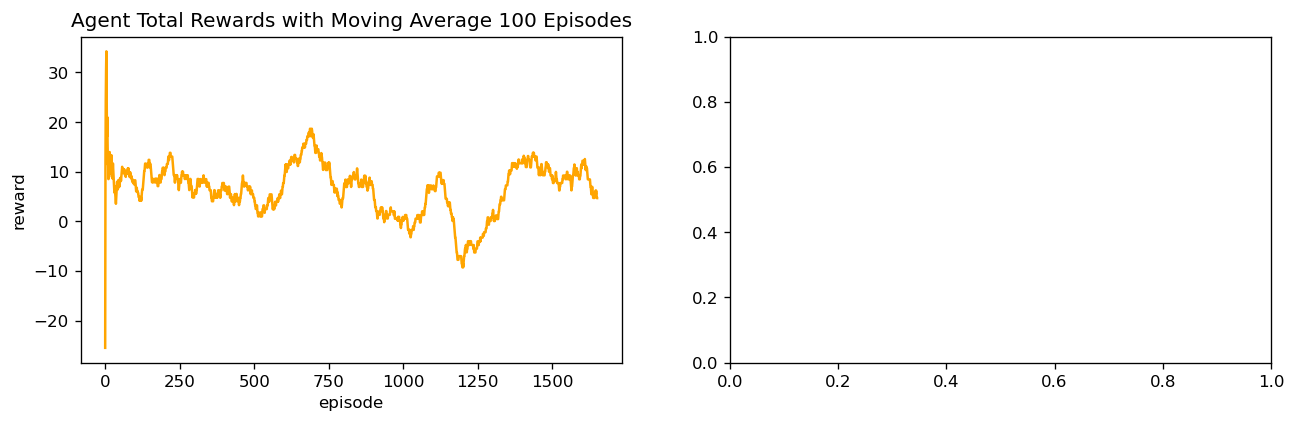

episode 650 	round 1 	epsilon 0.100
Exception ignored in: <function ScopedTFGraph.__del__ at 0x000001CC98EB6CA0>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 54, in __del__
    self.deleter(self.graph)
AttributeError: 'ScopedTFGraph' object has no attribute 'deleter'
Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x000001CC9B8DB0D0>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\weakref.py", line 346, in remove
    self = selfref()
KeyboardInterrupt: 


KeyboardInterrupt: 

In [7]:
for j in range(10):

    agent.reset_epsilon()

    for i in range(num_episodes):
        done = False
        tot_reward = 0

        observation = trainer.reset()
        obs = preprocess_board_state(observation)
        
        # print(obs.reshape(6, 7))

        while not done:

            # choose the best action
            action = agent.choose_action(obs)
            # print("action: ", action)
            
            # step the environment with action
            # store all returns
            observation_, reward, done, info = trainer.step(action)
            obs_ = preprocess_board_state(observation_)

            # print(obs_.reshape(6, 7))

            # calculate agent reward from environment response
            agent_reward = agent.get_agent_reward(reward, done)
            
            tot_reward += agent_reward
            
            # store this transition
            agent.update_replay_buffer((obs, action, reward, obs_, done))
            
            # update the current obs with new obs
            obs = obs_
            
            
            agent.learn()
        
        agent.evolve()

        # store final game result
        result.append(reward)
        # store total rewards
        rewards.append(tot_reward)
        # store average rewards
        avg_rewards.append(np.mean(rewards[-100:]))
        wl_ratio.append(np.mean(result[-100:]))
        


        if i % 50 == 0:
            live_plot(avg_rewards, i, j, agent.epsilon)
            
        # trainer.render(mode='json')
        
    agent.save_model('./models/test-model-dense')
    live_plot(avg_rewards, i, j, agent.epsilon)
live_plot(avg_rewards, i, j, agent.epsilon)

In [ ]:
# agent.save_model('./models/test-model-dense')

In [ ]:
from D3QNAgent import Agent
def my_agent(obs, config):
    # define agent
    agent = Agent(config)
    agent.load_model('./models/test-model-dense')

    # preprocessing of the state
    state = preprocess_board_state(obs)

    return agent.choose_action(state)

In [ ]:
env.reset()
# Play as the first agent against default "random" agent.
env.run([my_agent, playalong_agent])
env.render(mode="ipython", width=500, height=450)

In [ ]:
# def mean_reward(rewards):
#     return sum(r[0] for r in rewards) / float(len(rewards))
    
# print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [my_agent, "random"], num_episodes=10)))